## Modeling

In [99]:
# libraries for this project
import json
import pandas as pd
import numpy as np
from numpy import mean, std
from IPython.display import HTML
import matplotlib.pyplot as plt
from icecream import ic
#import seaborn as sns
import os.path
import sys
import gc
import feather
from icecream import ic
from sys import getsizeof
import time
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
%matplotlib inline
import matplotlib.dates as mdates
from matplotlib.ticker import MaxNLocator
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import r2_score
from matplotlib import pyplot
import seaborn as sns

# models
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
import xgboost as xgb
import catboost as cb
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingRegressor

In [100]:
# Pandas has a high consume of memory RAM usage
# release memory RAM
def release_memory(df):   
    del df
    gc.collect() 
    df = pd.DataFrame() # point to NULL
    print('memory RAM released.')

# Get start time 
start_time = time.time()

def transf_cat_num(df):

    print("preprocessing: the categorical and numerical feature now...")
    categorical_feature_names = list(df.select_dtypes(include='category').columns)
    numeric_feature_names = list(df.drop(categorical_feature_names, axis=1).columns)
    
    print("One Hot Encoder...")
    print(f'categorical features: {categorical_feature_names}')
    
    categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
                                            ('onehot', OneHotEncoder(handle_unknown='ignore'))] )
    
    numeric_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                                        ('scaler', StandardScaler())])

    # Two preprocessed steps together using the Column Transformer module
    preprocessor = ColumnTransformer(
    transformers=[('num', numeric_transformer, numeric_feature_names),
                  ('cat', categorical_transformer, categorical_feature_names)])
    
    return preprocessor

# Install requirements to this project
%pip install freeze
%pip install -r requirements.txt

ERROR: Could not find a version that satisfies the requirement freeze (from versions: none)
ERROR: No matching distribution found for freeze
Note: you may need to restart the kernel to use updated packages.
Processing /home/conda/feedstock_root/build_artifacts/aliyun-python-sdk-core_1606717026313/work
ERROR: Could not install packages due to an OSError: [Errno 2] No such file or directory: '/home/conda/feedstock_root/build_artifacts/aliyun-python-sdk-core_1606717026313/work'

Note: you may need to restart the kernel to use updated packages.


In [101]:
print("Loading dataset - to modeling...")

# loading data feather format
df = pd.read_feather('../data/dataset_featureselect.ftr')

Loading dataset - to modeling...


In [102]:
df.dtypes

longitude              float64
latitude               float64
housing_median_age     float64
total_rooms            float64
total_bedrooms         float64
population             float64
households             float64
median_income          float64
median_house_value     float64
ocean_proximity       category
dtype: object

## Pipeline

In [103]:
def pipeline_project(X, model):
    # Pipeline object
    print("setting the pipeline object ...")
    print('preprocessor...')
    preprocessor = transf_cat_num(X)

    feature_selection = SelectKBest(score_func=f_regression, k = 5)

    pipe = Pipeline(steps=[('preprocessor', preprocessor),
                            ('fs', feature_selection),
                            ('scaler', StandardScaler()),
                            ('model', model)])

    print('>>> pipeline defined!')    
    return pipe

## Stacking 

In [104]:
# get a stacking ensemble of models
#https://towardsdatascience.com/ensemble-methods-bagging-boosting-and-stacking-c9214a10a205
# https://www.kaggle.com/satishgunjal/ensemble-learning-bagging-boosting-stacking
def get_stacking():
    # define the base models
    level0 = list()
    level0.append(('RandomForestRegressor', RandomForestRegressor(n_estimators=5, random_state = 42, n_jobs = -1)))
    level0.append(('DecisionTreeRegressor', DecisionTreeRegressor()))
    level0.append(('XGBRegressor', xgb.XGBRegressor(objective="reg:linear", random_state=42)))
    level0.append(('CatBoost', cb.CatBoostRegressor(loss_function='RMSE')))
    level0.append(('LinearR', LinearRegression(n_jobs = -1)))

    # define meta learner model
    level1 = cb.CatBoostRegressor(loss_function='RMSE')

    # define the stacking ensemble
    model = StackingRegressor(estimators=level0, final_estimator=level1, cv=5)
    return model

## Split-out validation dataset

In [105]:
# Regression models
def get_models():
  models['RandomForest']=RandomForestRegressor(n_estimators=5, random_state = 42, n_jobs = -1)
  models['DecisionTree']=DecisionTreeRegressor()
  #models['KNeighbors']=KNeighborsRegressor()
  models['XGBoost']=xgb.XGBRegressor(objective="reg:linear", random_state=42)
  models['CatBoost'] = cb.CatBoostRegressor(loss_function='RMSE')
  models['LinearR']= LinearRegression(n_jobs = -1) # Use all computer cores
  models['stacking'] = get_stacking()
  return models

In [106]:
df.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity'],
      dtype='object')

tal: 1.8s	remaining: 976ms
649:	learn: 57411.3553994	total: 1.81s	remaining: 973ms
650:	learn: 57407.9314831	total: 1.81s	remaining: 971ms
651:	learn: 57402.1350542	total: 1.81s	remaining: 968ms
652:	learn: 57399.6989175	total: 1.81s	remaining: 965ms
653:	learn: 57392.6678780	total: 1.82s	remaining: 962ms
654:	learn: 57384.8286595	total: 1.82s	remaining: 958ms
655:	learn: 57375.9137376	total: 1.82s	remaining: 956ms
656:	learn: 57366.6546832	total: 1.82s	remaining: 953ms
657:	learn: 57361.7934981	total: 1.83s	remaining: 950ms
658:	learn: 57354.3075461	total: 1.83s	remaining: 947ms
659:	learn: 57347.0813453	total: 1.83s	remaining: 944ms
660:	learn: 57336.3663663	total: 1.83s	remaining: 940ms
661:	learn: 57333.0729653	total: 1.83s	remaining: 937ms
662:	learn: 57327.7882119	total: 1.84s	remaining: 936ms
663:	learn: 57327.0113775	total: 1.84s	remaining: 934ms
664:	learn: 57317.0313842	total: 1.85s	remaining: 931ms
665:	learn: 57306.0075023	total: 1.85s	remaining: 928ms
666:	learn: 57304.490

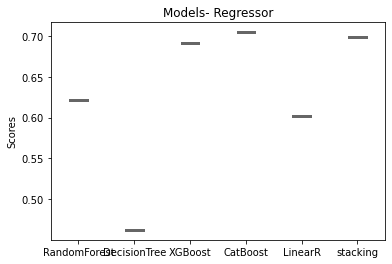

In [107]:
models = {}
models = get_models()

print(models)

# evaluate the models and store results
results = []
names = []

for name, model in models.items():

    # Alternatively X and y can be obtained directly from the dataframe attribute:
    X = df.drop('median_house_value', axis=1) # drop the column target
    y = df['median_house_value'] # target

    pipe = pipeline_project(X, model)

    ## Split-out validation dataset
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.14, random_state=1)

    ## Training the model
    #print('training the model...')

    ## Fitting...
    pipe.fit(X_train, y_train)

    ## prediction
    print('prediction...')
    y_pred = pipe.predict(X_test)
    
    scores = r2_score(y_test, y_pred)
    # store the results
    results.append(scores)

    ## model names
    names.append(name)
    
    # summarize the performance along the way
    print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))

    #release_memory(X)
    #release_memory(y)

ic(names)
ic(results)

# plot model performance for comparison
sns.boxplot(x=names, y=results, palette="Set3", linewidth=3, width=0.3)
plt.title("Models- Regressor")
plt.ylabel("Scores") # MAE -- Mean Absolute Error
#sns.xlabel("Models")
plt.show()

[0.20002475957017063, 0.6362859123365786, 0.011944301828356856, 0.14832332501503193, 0.003421701249862069]
features selected:
the K best features selected to the model (RandomForest): ['latitude', 'median_income', 'ocean_proximity']
######################################################################
model: RandomForest
latitude.......: 20.0 %
median_income.......: 63.63 %
ocean_proximity.......: 1.19 %


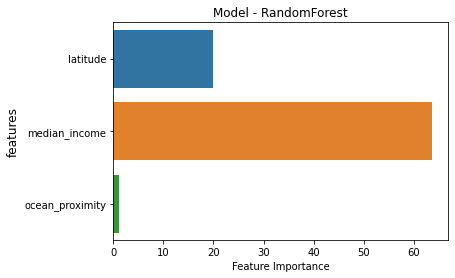

######################################################################
[0.19804428266231938, 0.6403309549287761, 0.011196253229275087, 0.14654542504603163, 0.003883084133597753]
features selected:
the K best features selected to the model (DecisionTree): ['latitude', 'median_income', 'ocean_proximity']
######################################################################
model: DecisionTree
latitude.......: 19.8 %
median_income.......: 64.03 %
ocean_proximity.......: 1.12 %


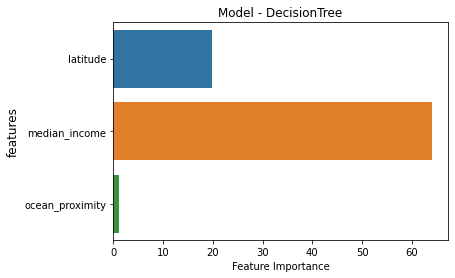

######################################################################
[0.039531298, 0.15205094, 0.04728548, 0.73226166, 0.028870597]
features selected:
the K best features selected to the model (XGBoost): ['latitude', 'median_income', 'ocean_proximity']
######################################################################
model: XGBoost
latitude.......: 3.95 %
median_income.......: 15.21 %
ocean_proximity.......: 4.73 %


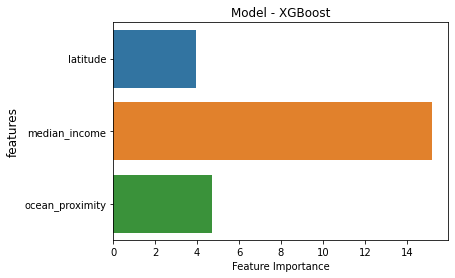

######################################################################
[32.84366998613717, 35.9768861832965, 4.933509797656067, 24.446042647191465, 1.799891385718791]
features selected:
the K best features selected to the model (CatBoost): ['latitude', 'median_income', 'ocean_proximity']
######################################################################
model: CatBoost
latitude.......: 32.84 %
median_income.......: 35.98 %
ocean_proximity.......: 4.93 %


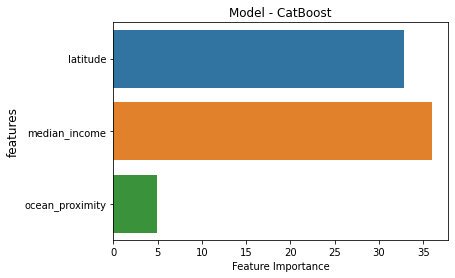

######################################################################


In [108]:
feature_names =list(X.columns)

# feature importance
for name, model in models.items():

    if(name == 'LinearR' or name == 'stacking'):
        continue

    list_feat_importances = list(model.feature_importances_)
    print(list_feat_importances)
    
    dict_feat_importances = {}

    print('features selected:')
    mask = pipe.named_steps['fs'].get_support()

    new_features = [] # The list of your K best features

    for bool, feature in zip(mask, feature_names):
        if(bool and (feature != 'p_esc_final')):
            new_features.append(feature)
            
    print(f'the K best features selected to the model ({name}): {new_features}')

    i=0

    print('######################################################################')
    print(f'model: {name}')

    # list of feature importances
    for ilist in new_features:

        if(name=='CatBoost'):
            dict_feat_importances[ilist] = list_feat_importances[i] # porcentagem %
            print(f"{ilist}.......: {round(dict_feat_importances[ilist], 2)} %")
            i=i+1
        else:
            dict_feat_importances[ilist] = list_feat_importances[i]*100 # porcentagem %
            print(f"{ilist}.......: {round(dict_feat_importances[ilist], 2)} %")
            i=i+1

    x_axis = list(dict_feat_importances.values())
    y_axis = list(dict_feat_importances.keys())

    sns.barplot(x_axis, y_axis)
    
    plt.ylabel('features', fontsize=12)
    plt.xlabel('Feature Importance')
    plt.title(f"Model - {name}")
    plt.savefig(f'figures/feature_importance_model_{name}.png')
    plt.savefig(f'figures/feature_importance_model_{name}.pdf')
    # Show graphic
    plt.show()


    print('######################################################################')


In [109]:
# evaluate a give model using cross-validation
def evaluate_model(model, X, y):
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise')
	return scores

In [110]:
# Alternatively X and y can be obtained directly from the dataframe attribute:
X = df.drop('median_house_value', axis=1) # drop the column target
y = df['median_house_value'] # target

le = LabelEncoder()

X['ocean_proximity'] = le.fit_transform(X['ocean_proximity'])

>RandomForest -35134.172 (736.767)
>DecisionTree -42658.438 (942.969)
>XGBoost -31445.480 (611.316)
>CatBoost -30052.537 (477.110)
>LinearR -50841.067 (769.431)
>stacking -33223.738 (651.688)


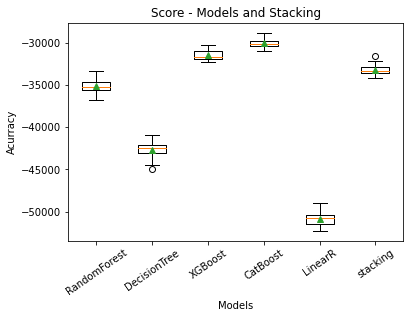

In [112]:
# Call the get_models()
models=get_models()

# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	scores = evaluate_model(model, X, y)
	results.append(scores)
	names.append(name)
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.title("Score - Models and Stacking")
pyplot.ylabel("Acurracy")
pyplot.xlabel("Models")
pyplot.xticks(rotation=35)
pyplot.show()